In [1]:
#import
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, metrics)
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from functools import partial
import pandas
import networkx as nx
import numpy as np
import geopandas as gpd
import shapely
from scipy.stats.stats import pearsonr

In [2]:
#load the dual graph
graph = Graph.from_file("./VA_precincts/VA_precincts.shp")
gdf = gpd.read_file("./VA_precincts/VA_precincts.shp")

/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(887, 892), (892, 914), (887, 893)}
  overlaps
/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/graph.py:249: UserWarning: NA values found in column G17DGOV!
  warnings.warn("NA values found in column {}!".format(column))


In [3]:
print("Sample node: ", graph.nodes[0])

Sample node:  {'boundary_node': False, 'area': 5227879.134813407, 'precinct': 'Glenkirk', 'locality': 'Prince William County', 'loc_prec': 'Prince William County Glenkirk', 'district': 'Congressional District 1', 'G18DHOR': '980.0', 'G18DSEN': '1044.0', 'G18OHOR': '0.0', 'G18OSEN': '32.0', 'G18RHOR': '950.0', 'G18RSEN': '856.0', 'G17DGOV': '715.0', 'G17DLTG': '701.0', 'G17DATG': '698.0', 'G17DHOD': '650.0', 'G17RGOV': '744.0', 'G17RLTG': '763.0', 'G17RATG': '769.0', 'G17RHOD': '804.0', 'G17OHOD': '0.0', 'G17OGOV': '13.0', 'G16DPRS': '1083.0', 'G16RPRS': '1155.0', 'G16OPRS': '119.0', 'G16DHOR': '920.0', 'G16RHOR': '1320.0', 'G16OHOR': '78.0', 'TOTPOP': 3651.999991623403, 'NH_WHITE': 2324.9999940296734, 'NH_BLACK': 304.0000000887875, 'NH_AMIN': 8.000000001742087, 'NH_ASIAN': 591.999997592487, 'NH_NHPI': 0.999999986279534, 'NH_OTHER': 3.999999996110087, 'NH_2MORE': 101.99999983433004, 'HISP': 316.000000093993, 'H_WHITE': 208.9999998809002, 'H_BLACK': 8.000000085355632, 'H_AMN': 6.311268e-

In [4]:
#fix some strings which should be numbers
for n in graph.nodes():
    graph.nodes[n]['G16DPRS'] = float(graph.nodes[n]['G16DPRS'])
    graph.nodes[n]['G16RPRS'] = float(graph.nodes[n]['G16RPRS'])


In [5]:
#elections and updaters
pop_col = "TOTPOP"
election_names = [
    "PRES16",
]
election_columns = [
    ["G16DPRS", "G16RPRS"],
]
updaters1 = {
    "population": updaters.Tally(pop_col, alias="population"),
    "cut_edges": cut_edges,
}

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(len(election_names))
]
election_updaters = {election.name: election for election in elections}
updaters1.update(election_updaters)

In [6]:
#real partitions
partition_CD12 = Partition(graph, "CD_12", updaters1)
partition_CD16 = Partition(graph, "CD_16", updaters1)
partition_list = [
    partition_CD12, partition_CD16]
label_list = [
    'Enacted12', 'Enacted16']
ideal_population = sum(partition_CD12["population"].values())/len(partition_CD12)
print("Ideal population: ", ideal_population)

Ideal population:  727365.8181426955


In [23]:
#ReCom run setup
proposal = partial(recom,
                   pop_col=pop_col,
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(partition_CD12["cut_edges"])
)
pop_constraint = constraints.within_percent_of_ideal_population(partition_CD12, 0.15)
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=partition_CD12,
    total_steps=5000
)

In [8]:

def ccs_over_districts(part, threshold, subgraph_ccs=None):
    cc_splits = 0
    ccs = 0
    if (subgraph_ccs==None):
        graph = part.graph
        nodes_over_threshold = []
        for i in graph.nodes:
            if float(graph.nodes[i]["G16DPRS"])+float(graph.nodes[i]["G16RPRS"]) != 0:
                if graph.nodes[i]["G16DPRS"]/(
                    graph.nodes[i]["G16DPRS"]+graph.nodes[i]["G16RPRS"]) > threshold:
                    nodes_over_threshold.append(i)
        subgraph = graph.subgraph(nodes_over_threshold)
        connected_components = nx.connected_components(subgraph)
    else:
        connected_components = subgraph_ccs
    for cc in connected_components:
        ccs+=1
        for district in part.assignment.parts:
            if len(cc & part.assignment.parts[district]) != 0:
                cc_splits +=1
    return cc_splits-ccs


In [9]:
#districts intersected by cc
def cc_adjacency(part, cc_list=None):
    cc_adjacency = np.zeros((len(cc_list),len(cc_list)))
    ccs_in_district = {d:[] for d in part.parts}
    for cc in range(len(cc_list)):
        for d in part.parts:
            if len(cc_list[cc] & part.assignment.parts[d]) != 0:
                ccs_in_district[d].append(cc)
    for d in part.parts:
        for cc1 in ccs_in_district[d]:
            for cc2 in ccs_in_district[d]:
                cc_adjacency[cc1][cc2] = 1
    return cc_adjacency

In [10]:
def draw_blue_islands(graph, gdf, threshold):
    ass = {x:1 for x in graph.nodes}
    nodes_over_threshold = []
    for i in graph.nodes:
        if float(graph.nodes[i]["G16DPRS"])+float(graph.nodes[i]["G16RPRS"]) != 0:
            if graph.nodes[i]["G16DPRS"]/(
                graph.nodes[i]["G16DPRS"]+graph.nodes[i]["G16RPRS"]) > threshold:
                nodes_over_threshold.append(i)
    subgraph = graph.subgraph(nodes_over_threshold)
    connected_components = nx.connected_components(subgraph)
    for cc in connected_components:
        for node in cc:
            ass[node]=0
    part = GeographicPartition(graph, ass)
    part.plot(gdf, cmap='seismic')

In [22]:
xvals = [x/100 for x in range(0,100)]
subgraph_ccs = {}
for x in xvals:
    nodes_over_threshold = []
    for i in graph.nodes:
        if float(graph.nodes[i]["G16DPRS"])+float(graph.nodes[i]["G16RPRS"]) != 0:
            if graph.nodes[i]["G16DPRS"]/(
                graph.nodes[i]["G16DPRS"]+graph.nodes[i]["G16RPRS"]) > x:
                nodes_over_threshold.append(i)
    subgraph = graph.subgraph(nodes_over_threshold)
    subgraph_ccs_gen = nx.connected_components(subgraph)
    subgraph_ccs[x] = [c for c in subgraph_ccs_gen if sum(
        [graph.nodes[n][pop_col] for n in c]) > 0.05*ideal_population]

Threshold =  0.95 , components =  2


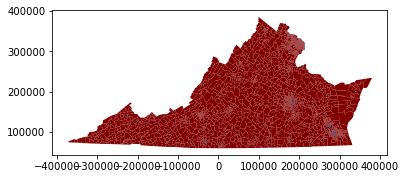

Threshold =  0.9 , components =  3


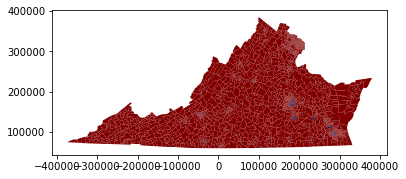

Threshold =  0.85 , components =  4


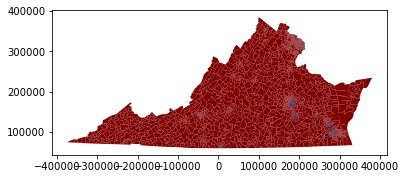

Threshold =  0.8 , components =  7


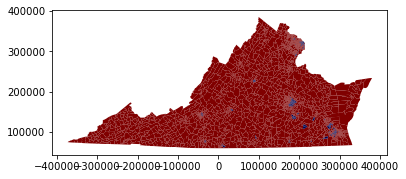

Threshold =  0.75 , components =  8


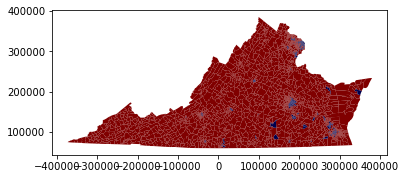

Threshold =  0.7 , components =  9


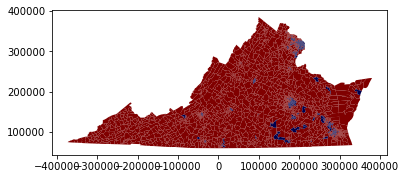

Threshold =  0.65 , components =  8


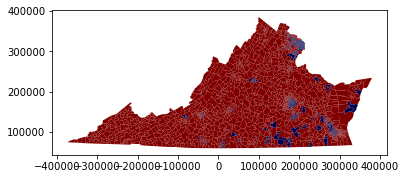

Threshold =  0.6 , components =  9


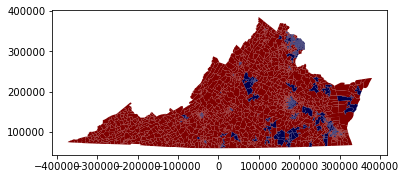

Threshold =  0.55 , components =  9


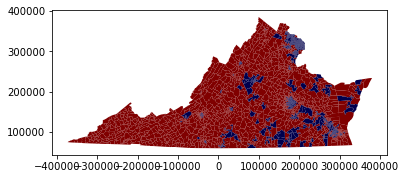

Threshold =  0.5 , components =  9


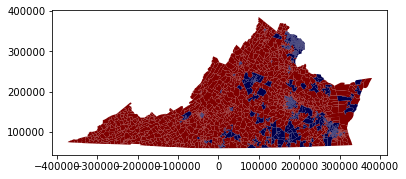

Threshold =  0.44999999999999996 , components =  10


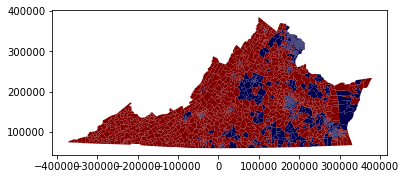

Threshold =  0.4 , components =  10


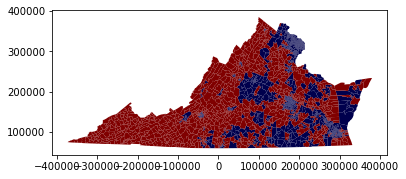

Threshold =  0.35 , components =  5


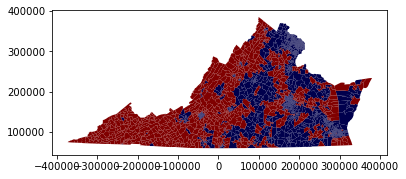

Threshold =  0.30000000000000004 , components =  5


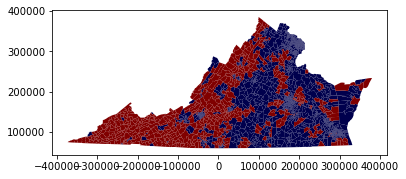

In [21]:
for x in [1-x/20 for x in range(1,15)]:
    print("Threshold = ", round(x,2), ", components = ", len(subgraph_ccs[round(x,2)]))
    draw_blue_islands(graph, gdf, x)
    plt.show()

In [24]:
timer = 0
xvals = [x/100 for x in range(0,100)]
data = {x:[] for x in xvals}
seats = []
for state in chain:
    timer+=1
    if (timer %100 == 0):
        print(timer, end=" ")
    for x in xvals:
        data[x].append(ccs_over_districts(state, x, subgraph_ccs=subgraph_ccs[x]))
    seats.append(state['PRES16'].seats('Democratic'))

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 

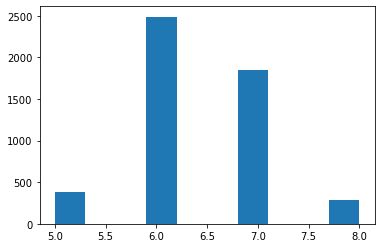

Text(0, 0.5, 'Average districts intersecting connected component')

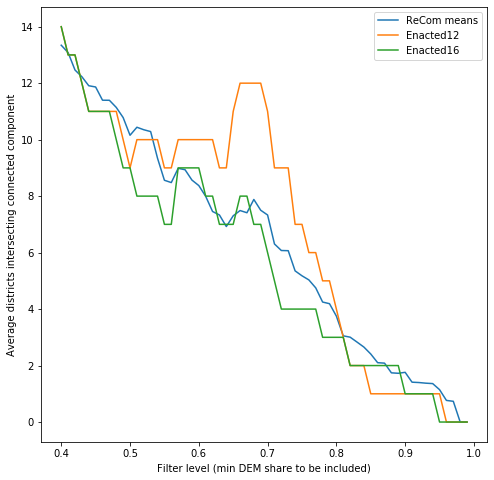

In [35]:
xvals = [x/100 for x in range(40,100)]

plt.hist(seats)
plt.show()

plt.figure(figsize=(8,8))

'''
for i in range(min(seats), max(seats)+1):
    data_means = []
    for x in xvals:
        data_means.append(
            np.mean([data[x][z] for z in range(len(data[x])) if seats[z]==i]))
    plt.plot(xvals, data_means, label="ReCom samples with "+str(i)+" DEM seats.")
'''
data_means = []
for x in xvals:
    data_means.append(
        np.mean([data[x][z] for z in range(len(data[x]))]))
plt.plot(xvals, data_means, label="ReCom means")

for k in range(len(partition_list[0:2])):
    list1 = []
    for i in xvals:
        copy = subgraph_ccs[i]
        list1.append(ccs_over_districts(partition_list[k], i, subgraph_ccs=copy))
    plt.plot(xvals, list1, label=label_list[k])
    plt.legend(loc='lower left')
plt.legend(loc='best')
plt.xlabel("Filter level (min DEM share to be included)")
plt.ylabel("Average districts intersecting connected component")

    

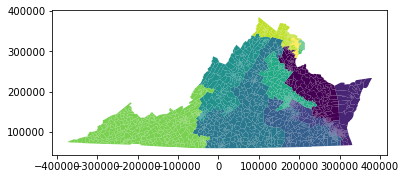

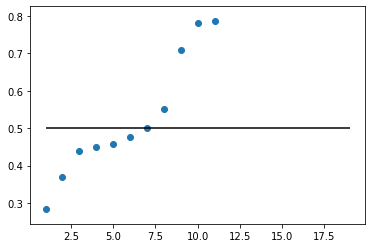

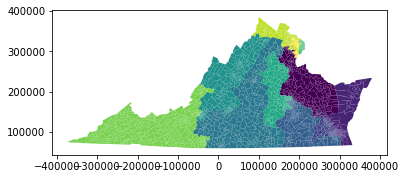

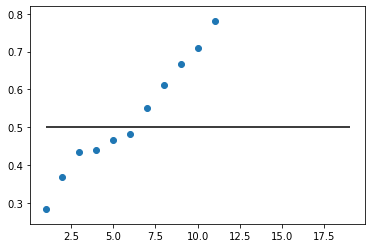

In [28]:
partition_CD12.plot(gdf)
plt.show()
plt.scatter(range(1,12), sorted(partition_CD12['PRES16'].percents('Democratic')))
plt.hlines(0.5, 1, 19)
plt.show()
partition_CD16.plot(gdf)
plt.show()
plt.scatter(range(1,12), sorted(partition_CD16['PRES16'].percents('Democratic')))
plt.hlines(0.5, 1, 19)
plt.show()

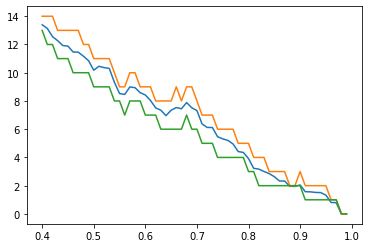

In [34]:
for i in [7]:
    data_means = []
    data_maxes = []
    data_mins = []
    for x in xvals:
        data_means.append(
            np.mean([data[x][z] for z in range(len(data[x])) if seats[z]==i]))
        data_maxes.append(
            np.quantile([data[x][z] for z in range(len(data[x])) if seats[z]==i], 0.75))
        data_mins.append(
            np.quantile([data[x][z] for z in range(len(data[x])) if seats[z]==i], 0.25))
    plt.plot(xvals, data_means, label="Mean of samples with "+str(i)+" DEM seats.")
    plt.plot(xvals, data_maxes, label="Max samples with "+str(i)+" DEM seats.")
    plt.plot(xvals, data_mins, label="Min samples with "+str(i)+" DEM seats.")

### Vector of intersections

In [ ]:
#districts intersected by cc
def splits_by_cc(part, cc_list):
    cc_splits = np.zeros(len(cc_list))
    for cc in range(len(cc_list)):
        for d in part.parts:
            if len(cc_list[cc] & part.assignment.parts[d]) != 0:
                cc_splits[cc]+=1
    return cc_splits

In [ ]:
timer = 0
xvals = [x/20 for x in range(2,18)]
data = {x:[] for x in xvals}
seats = []
for state in chain:
    timer+=1
    if (timer %100 == 0):
        print(timer, end=" ")
    for x in xvals:
        data[x].append(splits_by_cc(state, subgraph_ccs[x]))
    seats.append(state['PRES16'].seats('Democratic'))
plt.hist(seats, bins=[x-0.5 for x in range(min(seats), max(seats)+2)])

In [ ]:
data_means = {}
data_std = {}
for x in xvals:
    data_means[x] = np.zeros(len(subgraph_ccs[x]))
    for i in range(len(data_means[x])):
        data_means[x][i] = np.mean([z[i] for z in data[x]])
    print(x, " mean vector: ", data_means[x], end = ", ")
    data_std[x] = np.mean(
        [np.linalg.norm(data_means[x]-v) for v in data[x] ]
    )
    print(x, " mean deviation: ", data_std[x])

In [ ]:
for k in range(len(partition_list)):
    deviations = []
    for x in xvals:
        deviations.append(np.linalg.norm(
            splits_by_cc(partition_list[k],subgraph_ccs[x])-data_means[x]))
    plt.plot(xvals, deviations, label=label_list[k])
    plt.legend(loc='lower left')
plt.plot(xvals, [data_std[x] for x in xvals], label="ReCom mean deviation")
plt.legend(loc='best')
plt.xlabel("Filter level (min DEM share to be included)")
plt.ylabel("Distance from ReCom mean")